In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [2]:
folds = 5
seed = 2605
lr = 0.01
epochs = 100
batch_size = 128

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

In [3]:
def fold_separation(train_df, folds, feat_cols, label):
    skf = StratifiedKFold(n_splits=folds)
    train_df['fold'] = np.zeros(train_df.shape[0])
    for i, (idxT, idxV) in enumerate(skf.split(train_df[feat_cols], train_df[label])):
        train_df.at[idxV, 'fold'] = i

In [4]:
df = pd.read_csv('Data/Bank/formated_bank.csv')
train_df = df[df['is_train'] == 1].reset_index(drop=True).sample(frac = 1)
test_df = df[df['is_train'] == 0].reset_index(drop=True).sample(frac = 1)
male_df = train_df[train_df['z'] == 1].copy().reset_index(drop=True)
female_df = train_df[train_df['z'] == 0].copy().reset_index(drop=True)
feature_cols = list(train_df.columns)
feature_cols.remove('y')
feature_cols.remove('z')
feature_cols.remove('label')
feature_cols.remove('is_train')
feature_cols.remove('intercept')
label = 'y'
fold_separation(male_df, folds, feature_cols, label)
fold_separation(female_df, folds, feature_cols, label)
train_df = pd.concat([male_df, female_df], axis=0).reset_index(drop=True)

In [5]:
train_df.shape

(4131, 22)

# Logistic Regression

## Sklearn

In [8]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=10000).fit(X=train_df[feature_cols].values, y=train_df[label].values)
clf.score(X=train_df[feature_cols].values, y=train_df[label].values)

0.9230210602759622

In [9]:
clf.score(X=test_df[feature_cols].values, y=test_df[label].values)

0.9103448275862069

In [10]:
clf = LogisticRegression(random_state=0, max_iter=10000).fit(X=male_df[feature_cols].values, y=male_df[label].values)
clf.score(X=train_df[feature_cols].values, y=train_df[label].values)

0.8818687969014767

In [11]:
clf = LogisticRegression(random_state=0, max_iter=10000).fit(X=female_df[feature_cols].values, y=female_df[label].values)
clf.score(X=train_df[feature_cols].values, y=train_df[label].values)

0.8937303316388284

## Utils

In [5]:
class model():
    
    def __init__(self, input_dim, lr):
         # shape of w (input_dim, 1)
        self.w = np.random.normal(loc=0.0, scale=1.0, size=(input_dim, 1))
        self.lr = lr
    
    def sigmoid(self, x):
        return np.exp(x)/(1 + np.exp(x))
    
    def forward(self, x):
        
        # shape of x (batch_size, input_dim)
        pred = self.sigmoid(np.dot(x, self.w))
        return pred
    
    def backward(self, x, pred, y):
        # shape of pred (batch_size, 1)
        # shape of y (batch_size, 1)
        # shape of x (batch_size, input_dim)
        self.grad = np.dot(x.T, (pred - y))/x.shape[0]
        
    def update(self):
        self.w = self.w - self.lr*self.grad

In [6]:
def logloss(y, pred):
    return -1*y*np.log2(pred + 1e-6) - (1 - y)*np.log2(1 - pred + 1e-6)

## Normal

In [7]:
df_train = pd.concat([male_df[male_df['fold'] != 0], female_df[female_df['fold'] != 0]], axis = 0).reset_index(drop=True)
df_valid = pd.concat([male_df[male_df['fold'] == 0], female_df[female_df['fold'] == 0]], axis = 0).reset_index(drop=True)

In [8]:
num_batch = int(len(df_train)/batch_size) + 1

In [9]:
clf = model(len(feature_cols), lr)

In [10]:
male_norm = []
female_norm = []
male_err = []
female_err = []
for i in range(epochs):
    temp = df_train.sample(frac = 1)
    X = temp[feature_cols+['z']]
    Y = temp[[label]]
    train_loss = 0
    male_ = []
    female_ = []
    for b in range(num_batch):
        x = X[b*batch_size:(b+1)*batch_size].reset_index(drop=True)
        y = Y[b*batch_size:(b+1)*batch_size].reset_index(drop=True)
        x_male_index = x[x['z'] == 1].index
        x_female_index = x[x['z'] == 0].index
        x = x[feature_cols].to_numpy()
        y = y.to_numpy()
        pred = clf.forward(x = x)
        grad = (pred - y)*x
        norm_grad_male = 0
        norm_grad_female = 0
        if (len(x_male_index) > 0):
            grad_male = np.mean(grad[x_male_index], axis = 0)
            norm_grad_male = np.linalg.norm(grad_male)
        if (len(x_female_index) > 0):
            grad_female = np.mean(grad[x_female_index], axis = 0)
            norm_grad_female = np.linalg.norm(grad_female)
        male_.append(norm_grad_male)
        female_.append(norm_grad_female)
        loss = np.mean(logloss(y, pred))
        train_loss += loss
        clf.backward(x = x, pred=pred, y = y)
        clf.update()
    male_ = np.array(male_)
    female_ = np.array(female_)
    male_norm.append(np.mean(male_))
    female_norm.append(np.mean(female_))
    male_err.append(np.std(male_))
    female_err.append(np.std(female_))

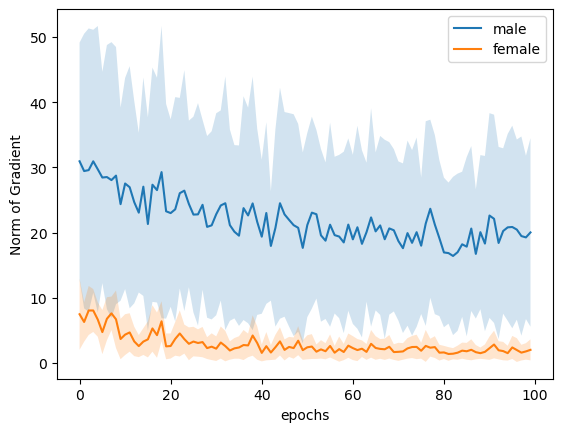

In [11]:
male_norm = np.array(male_norm)
female_norm = np.array(female_norm)
male_err = np.array(male_err)
female_err = np.array(female_err)


plt.plot(range(len(male_norm)), male_norm, label='male')
plt.plot(range(len(female_norm)), female_norm, label='female')
plt.xlabel('epochs')
plt.ylabel('Norm of Gradient')
plt.fill_between(range(len(male_norm)), male_norm-male_err, male_norm+male_err, alpha=0.2)
plt.fill_between(range(len(female_norm)), female_norm-female_err, female_norm+female_err,alpha=0.2)
plt.legend()